# Twitter Sentiment Analysis: Classification

Now that we are done preprocessing the data and we have a rough idea of how our data look like, we can move on
and start the process of classification.

When modeling texts, one problem that is often encountered is that texts are always messy, they don't have a well-defined structure. In most of the cases, machine learning models would like to work with numerical values so they can represent elements in the space with numerical features.

We will apply several approaches in order to get some results:
- Bag Of Words
- TF-IDF
- Word embeddings

Based on the approaches chosen the preprocessing of the text data will be different

For now, import all the libraries that will be needed and the preprocessed dataset.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
from ast import literal_eval
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv('preprocessed_data.csv', converters={"message": literal_eval})
df = df.astype({'preprocessed_text': 'str'})
df.head(10)

,sentiment,message,original_message,preprocessed_text
0,-1,"[climate, change, interest, hostel, global, wa...",@tiniebeany climate change is an interesting h...,climate change interest hostel global warm pla...
1,1,"[watch, beforetheflood, right, travel, world, ...",RT @NatGeoChannel: Watch #BeforeTheFlood right...,watch beforetheflood right travel world tackle...
2,1,"[fabulous, leonardo, decaprio, film, climate, ...",Fabulous! Leonardo #DiCaprio's film on #climat...,fabulous leonardo decaprio film climate change...
3,1,"[watch, amaze, documentary, leonardodicaprio, ...",RT @Mick_Fanning: Just watched this amazing do...,watch amaze documentary leonardodicaprio clima...
4,1,"[beforetheflood, watch, beforetheflood, right,...",#BeforeTheFlood Watch #BeforeTheFlood right he...,beforetheflood watch beforetheflood right trav...
5,1,"[vital, public, health, community, address, cl...",RT @DrDeJarnett: It's vital that the public he...,vital public health community address climate ...
6,1,"[bangladesh, not, cause, climate, change, coun...","Bangladesh did not cause climate change, so th...",bangladesh not cause climate change country no...
7,1,"[now, time, need, strong, ft, ), work, hardest...",Now's the time: we need a strong #FTT that wor...,now time need strong ft ) work hardest hit cli...
8,1,"[problem, global, reason, continue, resist, il...",RT @littoralsociety: The problem with global w...,problem global reason continue resist illustra...
9,1,"[one, easy, way, help, combat, climate, change...",RT @NatGeoChannel: One of the easiest ways to ...,one easy way help combat climate change daily ...


We need to divide our data into training and testing data.
We will use a ratio: *train -> 80%* <---> *test -> 20%*

In [4]:
# Using stratify we are creating balanced datasets
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

In [5]:
y_test = y_test.values
y_train = y_train.values

We write now the `print_accuracy(classifier, X_train, y_train, X_test, y_test)` function which, given a classifier and training and test data, will print the training accuracy, testing accuracy and f1-score, along with a confusion matrix.

Everything can be easily done by using the functions `sklearn.metrics.accuracy_score()` and `sklearn.metrics.classification_report()`

In [6]:
def print_accuracy(clf, X_train, y_train, X_test, y_test):
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    print('Train accuracy is:', accuracy_score(y_train_pred, y_train))
    print('Test accuracy is:', accuracy_score(y_test_pred, y_test))
    print(classification_report(y_test, y_test_pred))

    ax = plt.subplot()
    sns.heatmap(confusion_matrix(y_test, y_test_pred, normalize='true'), cmap='RdBu_r',annot=True, ax=ax)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.show()

***

## Preprocessing with Bag of Words (BoW)

The simplest approach that can be done when processing text is applying the so called "Bag Of Words" approach: in rough words, a bag-of-words is a representation of the text that describes the occurrences of words inside a sentence or a document.

It is called "bag" because we are putting all the words that we find inside a bag, where every spatial relationship of the words in the sentence is lost: we look only at the counts of the words.
This approach makes the modeling of data simple (it's very easy to estimate probabilities for example) but at the same time its simplicity can be a drawback.
Among these drawbacks we may find: the sparsity of the data, the huge size of the feature vectors (every word = 1 feature) and the impossibility of learning something for similar words (e.g. ball and balls will have 2 completely different features even if they are in fact the same word).

We can increase the complexity of the model also by using a variant, which I call "Bag of n-grams": here, instead of considering single words, you can look at n-grams.
In such a case case, if we consider unigrams, we fall back to the initial case of bag of words.
More considerations can be drawn from the data by considering bigrams, for example. However, keep in mind that the larger the history and the sparser the data will become.

Let us start by creating this bag of words in the simplest possible way.
To achieve this, we will use the CountVectorizer object.
Since we have already preprocessed and tokenized the data, we will overwrite both the tokenizer and the preprocessor so that they leave the data as they are.
I decided to use bigrams and 15000 max features according to the computational power I had available.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(tokenizer=lambda x:x, preprocessor=lambda x:x, ngram_range=(1,2), max_features=15000)
bow_train = count_vect.fit_transform(X_train).toarray()
bow_test = count_vect.transform(X_test).toarray()

### The class imbalance problem

As we have observed during the analysis of the dataset, we have a strong class imbalance between positive and negative class.
In order to address this, we have 3 possible choices:
  - Oversampling: Increase the patterns of the minority class by generating them artificially
  - Downsampling: Remove the patterns belonging to the majority class to balance the dataset
  - Leave the dataset unchanged

After performing some experiments downsampling was the worst choice (you were getting rid of 60% of the examples, thus reducing the ability of the model to learn).
Leaving the dataset unchanged was working better than downsampling but still the model had a bad f1-score.
The best choice instead was using SMOTE to oversample the minority class.
In simple words, SMOTE samples 2 random patterns from the minority class and along the segment connecting them is generating a new pattern in a random position.
Given 2 instances $x_1, x_2$ (randomly sampled), SMOTE generates $$ x' = x_1 + \lambda \cdot (x_2 - x_1) $$


In [8]:
sm = SMOTE(sampling_strategy='minority',random_state=42, k_neighbors=1)

oversampled_trainX, oversampled_trainY = sm.fit_resample(bow_train, y_train)

## Classifiers

### Naive Bayes Classifier

The Naive Bayes Classifier is classification model which relies on the Bayes rule in order to assign a class to a pattern.
$$ C_{MAP} = \underset{t}{\mathrm{argmax}}\ P(C_t|x) = \underset{t}{\mathrm{argmax}}\ \frac{P(x|C_t)P(C_t)}{P(x)} = \underset{t}{\mathrm{argmax}}\ P(x|C_t)P(C_t) $$
Where $P(x)$ was canceled since it's constant over $t$.

However, if the pattern $x$ has many features then we can rewrite it as $x = (x_1,x_2,...,x_d)$. When we look at it this way, the sparsity of the data is very high.
For this reason, the Naive Bayes Classifier makes the naive assumption that the features are *conditionally independent* (and **NOT** mutually independent).
This leads then to the following formula:
$$ C_{MAP} = \underset{t}{\mathrm{argmax}}\ P(C_t|x_1...x_d) = \underset{t}{\mathrm{argmax}}\ P(x_1...x_d|C_t)P(C_t)/P(x_1...x_d) = \underset{t}{\mathrm{argmax}}\ P(x_1...x_d|C_t)P(C_t) \approx \underset{t}{\mathrm{argmax}}\ P(C_t)\prod_{i=1}^{d}P(x_i|C_t)$$

Train accuracy is: 0.956230283911672
Test accuracy is: 0.874310239117106
              precision    recall  f1-score   support

          -1       0.61      0.57      0.59       772
           1       0.92      0.93      0.93      4121

    accuracy                           0.87      4893
   macro avg       0.76      0.75      0.76      4893
weighted avg       0.87      0.87      0.87      4893



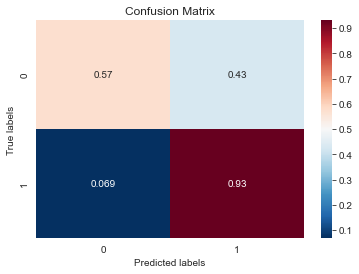

In [17]:
classifier = MultinomialNB()
classifier.fit(oversampled_trainX, oversampled_trainY)
print_accuracy(classifier, oversampled_trainX, oversampled_trainY, bow_test, y_test)

### Logistic Regression

Logistic regression is a non-linear regression model which is used to model the proability of a categorical variable with 2 outcomes.
It uses the gradient descent algorithm in order to minimize the cross-entropy loss (negative log-likelihood) defined as:
$$E = - \sum_{i=1}^{n} (1-y_i)log(1-s(\xi_i)) + y_ilog(s(\xi_i))$$
where $s(\xi_i)$ is the sigmoid function defined as: $$s(\xi_i) = \frac{1}{1 + e^{-q^Tx_i}}$$

To find the best value for the l2 regularization parameter $\lambda$, we used the sklearn.models.LogisticRegressionCV class which adopts by default a 5-fold cross-validation to decide the best value $\lambda$

Train accuracy is: 0.9527117204562
Test accuracy is: 0.8677702840792969
              precision    recall  f1-score   support

          -1       0.57      0.66      0.61       772
           1       0.93      0.91      0.92      4121

    accuracy                           0.87      4893
   macro avg       0.75      0.78      0.77      4893
weighted avg       0.88      0.87      0.87      4893



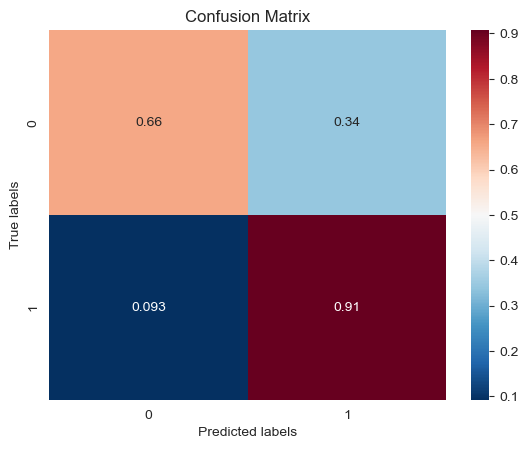

In [9]:
classifier = LogisticRegressionCV(random_state=42, n_jobs=-1, scoring='f1_macro').fit(oversampled_trainX, oversampled_trainY)
print_accuracy(classifier, oversampled_trainX, oversampled_trainY, bow_test, y_test)

It is observable from the data obtained that both models perform quite well when predicting the class 1, while their performance is relatively low when predicting the minority class -1.

### Linear SVM

Linear SVM is a classification algorithm which looks for the best separating hyperplane between 2 classes (even though it can be easily generalized to multiclass problems).
In this case, "best" separating hyperplane means the hyperplane which has the largest margin, i.e. the distance between the hyperplane and the pattern which is the closest to it.

The optimization problem (in the linearly separable case) that you need to solve is:
$$\begin{cases}
min \frac{<w,w>}{2}\\
y_i(<w,x_i> + b) \geq 1 \hspace{5mm} \forall i=1..n
\end{cases}$$

However, data are not always linearly separable, so you can use a factor (C) which will allow some patterns to be misclassified (so on the wrong side of the hyperplane) with some penalty. By changing the C, you are using a bigger or smaller penalty for misclassified patterns.

In order to find the best C, we will use GridSearchCV, which relies on the Cross Validation technique to choose the best attribute among a list provided in input.

Train accuracy is: 0.971699830138316
Test accuracy is: 0.8724708767627223
              precision    recall  f1-score   support

          -1       0.59      0.65      0.62       772
           1       0.93      0.91      0.92      4121

    accuracy                           0.87      4893
   macro avg       0.76      0.78      0.77      4893
weighted avg       0.88      0.87      0.88      4893



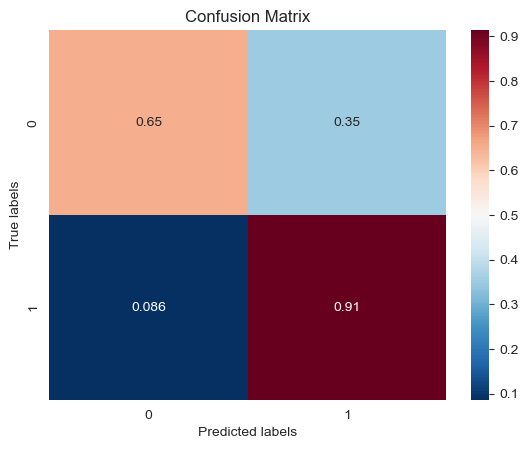

In [11]:
params = {'C':[0.1,0.5,1]}
svm = GridSearchCV(estimator=LinearSVC(), param_grid=params, n_jobs=-1, scoring='f1_macro')
svm.fit(oversampled_trainX,oversampled_trainY)
print_accuracy(svm.best_estimator_, oversampled_trainX, oversampled_trainY, bow_test, y_test)

### Trials with SVM Kernels

I also tried to use SVM kernels, however, due to the huge dimensionality of the feature space, this was not runnable in reasonable time. If your hardware is quite powerful, you may try to run the following cells and see if the results improve compared to the Linear SVM.

In [13]:
params = {'C':[1,5,10]}
svm = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=-1,scoring='f1_macro')
svm.fit(X_train, y_train)
print_accuracy(svm.best_estimator_, X_train, y_train, X_test, y_test)

ValueError: setting an array element with a sequence.

In [ ]:
params = {'degree': [3,4,5], 'C':[5, 10, 20]}
svm = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=params, n_jobs=-1, scoring='f1_macro')
svm.fit(X_train, y_train)
print_accuracy(svm.best_estimator_, X_train, y_train, X_test, y_test)

The model is very sparse, therefore the training time needed is very high and furthermore it is very prone to overfitting.

Moreover, Bag of Words loses the semantics of the meaning. Regardless of their position in the sentence,
the words would be considered just by how many times they appear inside the sentence itself.
For example "not bad" is considered as "not" and "bad". Which give a negative sentiment if considering the words by themselves, while the overall sentiment of this form is positive.

***

## TF-IDF

Unlike, bag-of-words, TF-IDF creates a normalized count over the whole dataset where each word count is divided by the number of documents the word appears in.

$$BoW(w, d) = \text{# times word w appears in document d}$$
$$Tf-Idf(w, d) = \frac{bow(w, d) \cdot N}{\text{# documents in which word w appears}}$$

Tf-idf makes rare words more prominent and effectively ignores common words.
Consider we have 10000 documents, and each of these documents has the word **the**. The IDF score becomes 1. Now, consider a word like **market**, and it appears in 100 documents, then its IDF score becomes 10000/100 = 100.

Now, on taking log transform of the IDF score, we get 0 for the word **the** and 2 for the word **market**. Thus, log transform tends to zero out all words that appear in all documents. It effectively means that the word is removed from the feature space.

A detailed guide and explanation about this approach can be found at:
https://mayurji.github.io/blog/2021/09/20/Tf-Idf

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), tokenizer=lambda x:x, preprocessor=lambda x:x, max_features=15000)
tf_idf_train = tf_idf_vect.fit_transform(X_train.values).toarray()
tf_idf_test = tf_idf_vect.transform(X_test.values).toarray()

In [13]:
sm = SMOTE(sampling_strategy='minority',random_state=42, k_neighbors=1)
oversampled_trainX, oversampled_trainY = sm.fit_resample(tf_idf_train, y_train)

## Bayes Classifier

Train accuracy is: 0.7750545983984469
Test accuracy is: 0.8969957081545065
              precision    recall  f1-score   support

          -1       0.82      0.44      0.58       772
           1       0.90      0.98      0.94      4121

    accuracy                           0.90      4893
   macro avg       0.86      0.71      0.76      4893
weighted avg       0.89      0.90      0.88      4893



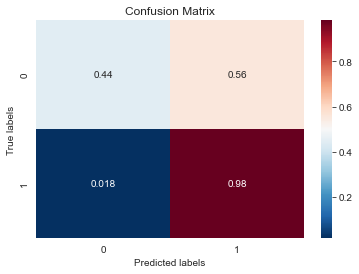

In [19]:
classifier = MultinomialNB(alpha=0.0)
classifier.fit(tf_idf_train, y_train)
print_accuracy(classifier, oversampled_trainX, oversampled_trainY, tf_idf_test, y_test)

## Logistic Regression

Train accuracy is: 0.781818733317156
Test accuracy is: 0.9082362558757409
              precision    recall  f1-score   support

          -1       0.78      0.59      0.67       772
           1       0.93      0.97      0.95      4121

    accuracy                           0.91      4893
   macro avg       0.85      0.78      0.81      4893
weighted avg       0.90      0.91      0.90      4893



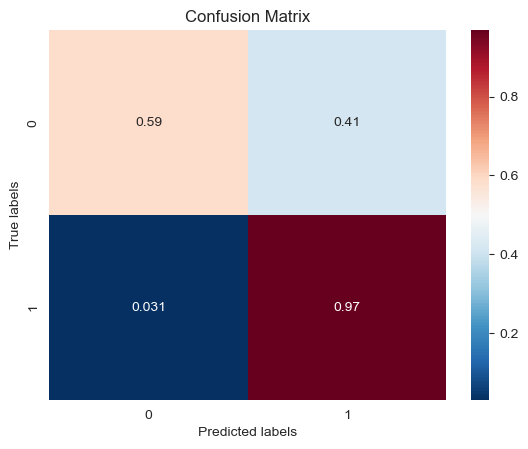

In [18]:
classifier = LogisticRegressionCV(random_state=42, n_jobs=-1, scoring='f1_macro')
classifier.fit(tf_idf_train, y_train)
print_accuracy(classifier, oversampled_trainX, oversampled_trainY, tf_idf_test, y_test)

## SVM

Train accuracy is: 0.7708990536277602
Test accuracy is: 0.91211935417944
              precision    recall  f1-score   support

          -1       0.81      0.58      0.68       772
           1       0.93      0.97      0.95      4121

    accuracy                           0.91      4893
   macro avg       0.87      0.78      0.81      4893
weighted avg       0.91      0.91      0.91      4893



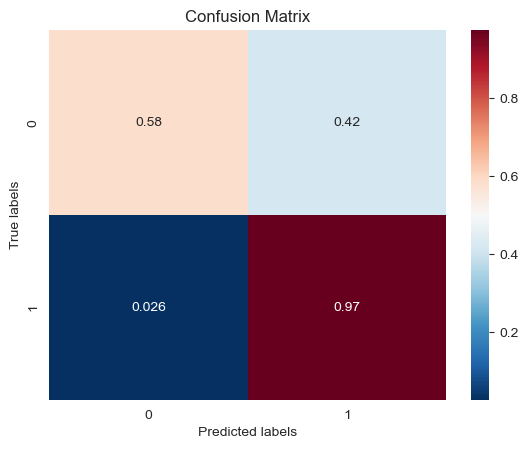

In [19]:
params = {'C':[0.1,0.5,1]}
svm = GridSearchCV(estimator=LinearSVC(), param_grid=params, n_jobs=-1, scoring='f1_macro')
svm.fit(tf_idf_train, y_train)
print_accuracy(svm.best_estimator_, oversampled_trainX, oversampled_trainY, tf_idf_test, y_test)

In [ ]:
params = {'C':[1,5,10]}
svm = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=-1,scoring='f1_macro')
svm.fit(oversampled_trainX, oversampled_trainY)
print_accuracy(svm.best_estimator_, oversampled_trainX, oversampled_trainY, X_test, y_test)

#### Considerations

Looking at the results from both these 2 approaches, we can see that Linear SVM with Tf-Idf is the best performing model, achieving a macro-avg f1-score of 81%.

Overall, every method relying on Tf-Idf was outperforming the best model trained using Bag Of Words: we can thus say that Tf-Idf is definitely the best choice.

***

# Word Embeddings

Word Embedding is a relatively new approach when talking about text processing.
It is a learned representation for text where words that have the same meaning have a similar representation, i.e. they are close to each other in the feature space.
Each word is mapped to a vector and these vector for a correct mapping is learned thanks to some neural networks.
This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning. This can be contrasted with the crisp but fragile representation in a bag of words model where, unless explicitly managed, different words have different representations, regardless of how they are used.

For example: imagine the word "dog" and "cat", with a BoW model, dog would have 1 feature and cat another totally separate feature.
In a BoW model, if a model learns that "dog is a pet" and that "cat has 4 legs", then this is the only knowledge the model acquires. On the other hand, with word embeddings, since dog and cat are close to each other, the model will also learn "dog has 4 legs" and "cat is a pet": they're placed close to each other in the feature space and therefore it is likely (not certain) that what holds for one word is also true for the other.

In [1]:
import gensim
from gensim import utils
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
from gensim.models import Word2Vec

Word2Vec is a word embedding of pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases.
This tool provides an efficient implementation of the continuous bag-of-words and skip-gram architectures for computing vector representations of words. These representations can be subsequently used in many natural language processing applications and for further research.

We can download the word2vec word embedding in 2 possible ways: use the one that works better for you by commenting one line among the following 2 possibilities.

In [1]:
# Downloading the word embedding
#word_emb = api.load('word2vec-google-news-300')

# Or load it from your local folder if you have it available on your hard-drive
word_emb = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

NameError: name 'gensim' is not defined

What we get as output from the lines of code we just ran is:
- An object of type [KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html), which is simply a map  $w \rightarrow \mathbf{e}_w \in \mathbb{R}^{300}$

### Obtaining the embedded representation of messages

Once that we downloaded the model, we need to compute the word embeddings for each message in our dataset.
We will use the following approach:
- for each message:
    compute the average of the representations for each token for each feature independently.
- drop the null columns (if all the tokens in the message don't exist, you would get a NaN)

In [90]:
def return_embedding_data(df_in, word_emb):
    df = df_in

    # Now we compute the average embedding score by looking at the words in the embedding. We do so only if the word is present inside the embedding dictionary
    df["sent_emb"] = df["message"].apply(lambda tok_sentence: np.mean([word_emb[word] for word in tok_sentence if word in word_emb.key_to_index], axis=0))
    df = df.dropna()
    #df = pd.concat([df['sent_emb'].apply(pd.Series), df['sentiment']], axis = 1)

    # Dividing the dataset into training and testing
    features_train, features_test, y_train, y_test = train_test_split(df['sent_emb'] , df["sentiment"], test_size=0.1, random_state=42, stratify=df["sentiment"])
    y_train = y_train.values
    y_test = y_test.values

    X_train = np.stack(features_train)
    X_test = np.stack(features_test)
    # let us try to do downsampling
    ind_pos = np.where(y_train == 1)[0]
    ind_neg = np.where(y_train == -1)[0]

    len_neg = len(ind_neg)

    # Downsampling
    ind_pos_downsampled = np.random.choice(ind_pos, size=int(2*len_neg), replace=False)
    y_train = np.hstack((y_train[ind_neg], y_train[ind_pos_downsampled]))
    X_train = np.vstack((X_train[ind_neg], X_train[ind_pos_downsampled]))

    #Upsampling
    # Upsampling the class with less data by using SMOTE, as done also before
    #sm = SMOTE(sampling_strategy='minority',random_state=42, k_neighbors=1)
    #X_train, y_train = sm.fit_resample(features_train, y_train)

    return df, X_train, y_train, X_test, y_test

After a few tests, downsampling to a rate positive:negative of 2:1 seemed to give the best performance.
So this is the approach used for the following steps.
If you want to try other approaches, you can just play with the comments of the "Downsampling" and "Upsampling" sections of this cell.

Obtain the training data by running the function we just defined.

In [91]:
df_word2vec, X_train, y_train, X_test, y_test = return_embedding_data(df, word_emb)

## Comparison between Word-Embeddings: Word2Vec vs Glove
### Logistic Regression Word2Vec
We will now try a logistic regressor classifier with 2 different word-embeddings: Word2Vec and Glove Twitter.
We will compare the performance over this classifier and decide which one to keep for the further experiments.

Train accuracy is: 0.8084799538505912
Test accuracy is: 0.8404907975460123
              precision    recall  f1-score   support

          -1       0.49      0.62      0.55       385
           1       0.93      0.88      0.90      2060

    accuracy                           0.84      2445
   macro avg       0.71      0.75      0.73      2445
weighted avg       0.86      0.84      0.85      2445



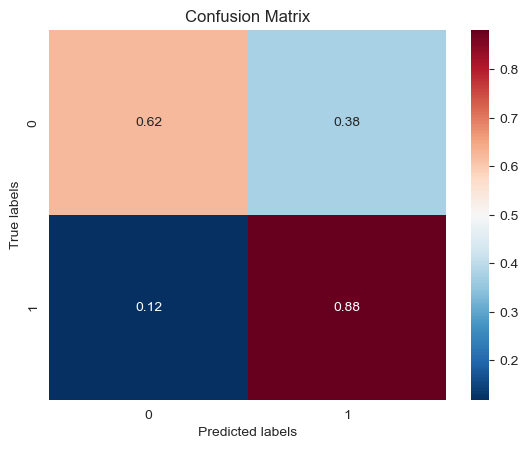

In [92]:
classifier = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', max_iter=5000)
classifier.fit(X_train, y_train) # 5-fold GridSearchCV followed by training of full model
print_accuracy(classifier, X_train, y_train, X_test, y_test)

These are the results for logistic regression with a Word2Vector embedding.


### Logistic Regression Glove

Let us see what would happen if we use Glove instead as embedder.
It is contains also a word-embedding trained over more than 2 billion tweets, so it is worth trying! The input vectors have a dimensionality of 200 features.

In [32]:
import gensim.downloader as api
glove_twitter = api.load("glove-twitter-200")

KeyboardInterrupt: 

In [61]:
df_glove, X_train, y_train, X_test, y_test = return_embedding_data(df, glove_twitter)

Train accuracy is: 0.7748293433323719
Test accuracy is: 0.8130879345603272
              precision    recall  f1-score   support

          -1       0.42      0.53      0.47       385
           1       0.91      0.87      0.89      2060

    accuracy                           0.81      2445
   macro avg       0.67      0.70      0.68      2445
weighted avg       0.83      0.81      0.82      2445



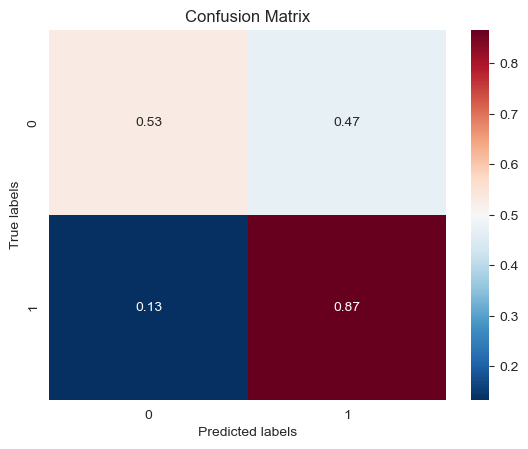

In [62]:
classifier = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', max_iter=5000)
classifier.fit(X_train, y_train) # 5-fold GridSearchCV followed by training of full model
print_accuracy(classifier, X_train, y_train, X_test, y_test)

### Results

We can see that the model seems to be performing better on Word2Vec (even if surprisingly, since Glove was trained on a Twitter dataset).
So for the next experiments we will use **Word2Vec**

In [63]:
df_word2vec, X_train, y_train, X_test, y_test = return_embedding_data(df, word_emb)

## Analysis of Classifiers with Word Embeddings
Once that we decided what's the best Word Embedding to use, we can test several different classifiers and pick the best one.

### Bayesian Classifier

Train accuracy is: 0.7202192096913759
Test accuracy is: 0.7517382413087934
              precision    recall  f1-score   support

          -1       0.34      0.63      0.44       385
           1       0.92      0.77      0.84      2060

    accuracy                           0.75      2445
   macro avg       0.63      0.70      0.64      2445
weighted avg       0.83      0.75      0.78      2445



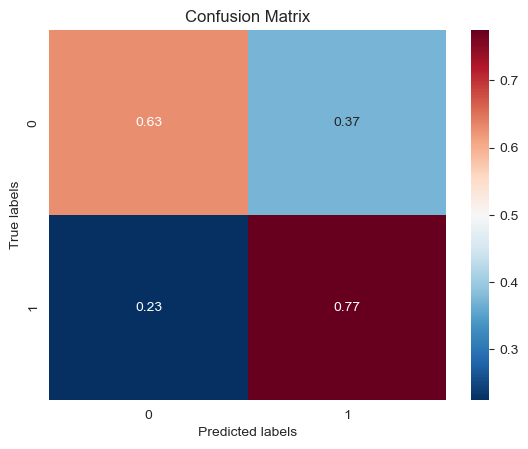

In [93]:
classifier = MultinomialNB(alpha=0.0)
classifier.fit(X_train, y_train)
print_accuracy(classifier, X_train, y_train, X_test, y_test)

### Linear SVM

Train accuracy is: 0.8115565810979714
Test accuracy is: 0.8445807770961146
              precision    recall  f1-score   support

          -1       0.51      0.63      0.56       385
           1       0.93      0.88      0.91      2060

    accuracy                           0.84      2445
   macro avg       0.72      0.76      0.73      2445
weighted avg       0.86      0.84      0.85      2445



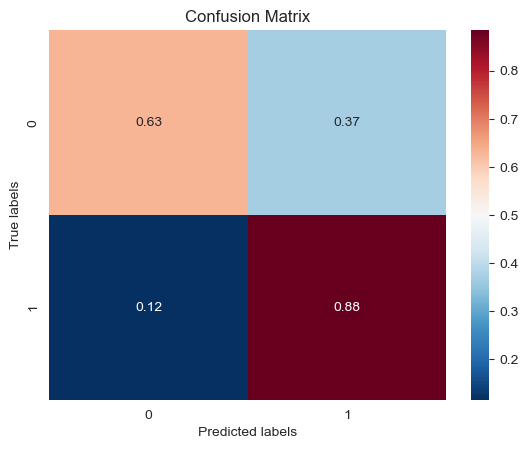

In [94]:
params = {'C':[1,5,10]}
svm = GridSearchCV(estimator=LinearSVC(), param_grid=params, n_jobs=-1, scoring='f1_macro')
svm.fit(X_train, y_train)
print_accuracy(svm.best_estimator_, X_train, y_train, X_test, y_test)

In [32]:
print(svm.best_params_)

{'C': 5}


### SVM with RBF Kernel

Train accuracy is: 0.9860590327853092
Test accuracy is: 0.8593047034764826
              precision    recall  f1-score   support

          -1       0.54      0.70      0.61       385
           1       0.94      0.89      0.91      2060

    accuracy                           0.86      2445
   macro avg       0.74      0.79      0.76      2445
weighted avg       0.88      0.86      0.87      2445



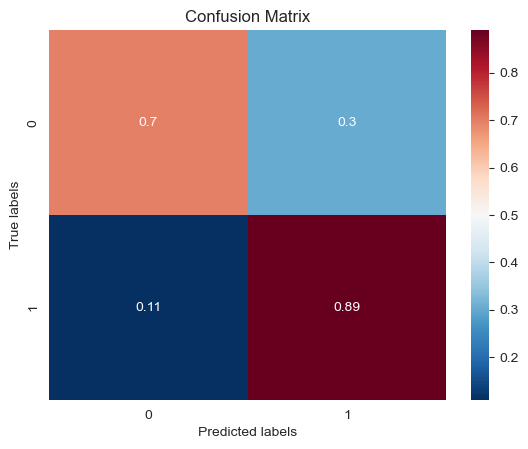

In [95]:
params = {'C':[1,5,10]}
svm = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=params, n_jobs=-1,scoring='f1_macro')
svm.fit(X_train, y_train)
print_accuracy(svm.best_estimator_, X_train, y_train, X_test, y_test)

In [96]:
print(svm.best_params_)

{'C': 10}


## SVM with Polynomial kernel

With GridSearchCV we will test different degress of the polynomial and different values for the penalising factor C for when the patterns get misclassified.

Train accuracy is: 0.9876934910104798
Test accuracy is: 0.8605316973415132
              precision    recall  f1-score   support

          -1       0.55      0.68      0.61       385
           1       0.94      0.89      0.92      2060

    accuracy                           0.86      2445
   macro avg       0.74      0.79      0.76      2445
weighted avg       0.88      0.86      0.87      2445



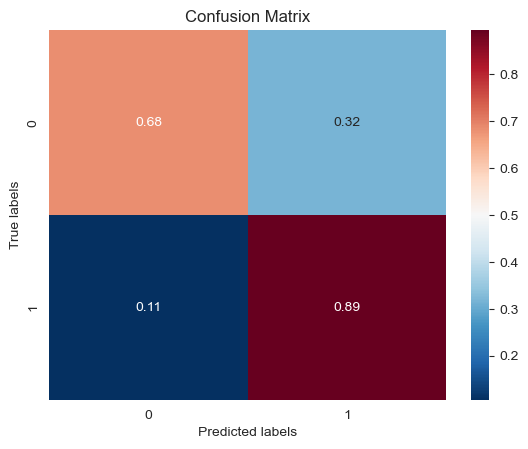

In [97]:
params = {'degree': [3,4,5], 'C':[5, 10, 20]}
svm = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=params, n_jobs=-1, scoring='f1_macro')
svm.fit(X_train, y_train)
print_accuracy(svm.best_estimator_, X_train, y_train, X_test, y_test)

In [98]:
print(svm.best_params_)

{'C': 5, 'degree': 4}


## Comparison with VADER

VADER ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis which is able to capture the polarity (positive or negative) as well as the intensity of this sentiment.
It can be applied directly to your data without any pre-training or fine-tuning.

The main idea of VADER is to assign to each word a degree of emotion (positive number for positive words and negative for negative words). These scores will be summed up to obtain the intensity of the whole text.

For example: Words like ‘love’, ‘good’, ‘nice’ all convey a positive sentiment. Also VADER is clever enough to understand the basic context of these words, such as “did not love” as a negative statement.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


              precision    recall  f1-score   support

          -1       0.18      0.47      0.26      3858
           1       0.86      0.59      0.70     20605

    accuracy                           0.57     24463
   macro avg       0.52      0.53      0.48     24463
weighted avg       0.75      0.57      0.63     24463



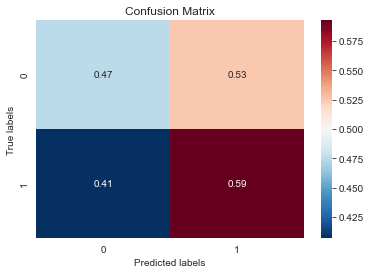

In [12]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df['vader_scores'] = df['original_message'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['vader_classification'] = df['vader_scores'].apply(lambda x: 1 if x>=0 else -1)

y_test = df['sentiment'].to_numpy()
y_test_pred = df['vader_classification'].to_numpy()

print(classification_report(y_test, y_test_pred))

ax = plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_test_pred, normalize='true'), cmap='RdBu_r',annot=True, ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

Contrary to what we were expecting, VADER performances are quite poor and all our trained models were performing better than this one.